In [7]:
# This is a one time step where we are basically taking the dataset and putting it in three different folders - train, validation and test.
from pathlib import Path
import shutil
from tqdm import tqdm
import os

image_dir = '/kaggle/input/hard-hat-detection/images'
anno_dir = '/kaggle/input/hard-hat-detection/annotations'

path_annotations = []
for i in Path(anno_dir).glob('*.xml'):
    path_annotations.append(i)
path_annotations = sorted(path_annotations) #contains path to 5000 annots

path_images = []
for i in Path(image_dir).glob('*.png'):
    path_images.append(i)
path_images = sorted(path_images) #contains path to 5000 images


# Split data : 80% Train, 10% Val & 10% Test.
path_train_annot = path_annotations[:4000]
path_train_images = path_images[:4000]

path_val_annot = path_annotations[4000:4500]
path_val_images = path_images[4000:4500]

path_test_annot = path_annotations[4500:5000]
path_test_images = path_images[4500:5000]


# Creating directories to put train, val & test data.
os.makedirs('./train/annotations',exist_ok = True)
os.makedirs('./train/images', exist_ok = True)
os.makedirs('./val/annotations', exist_ok = True)
os.makedirs('./val/images', exist_ok = True)
os.makedirs('./test/annotations', exist_ok = True)
os.makedirs('./test/images', exist_ok = True)
os.makedirs('./savedmodel', exist_ok = True)

#Copy data into train, val & test folders



for i, (path_annot, path_img) in tqdm(enumerate(zip(path_train_annot, path_train_images))):
    shutil.copy(path_img, './train/images/' + path_img.parts[-1])
    shutil.copy(path_annot, './train/annotations/' + path_annot.parts[-1])
    
for i, (path_annot, path_img) in tqdm(enumerate(zip(path_val_annot, path_val_images))):
    shutil.copy(path_img, './val/images/' + path_img.parts[-1])
    shutil.copy(path_annot, './val/annotations/' + path_annot.parts[-1])
    
for i, (path_annot, path_img) in tqdm(enumerate(zip(path_val_annot, path_val_images))):
    shutil.copy(path_img, './test/images/' + path_img.parts[-1])
    shutil.copy(path_annot, './test/annotations/' + path_annot.parts[-1])

4000it [00:13, 288.99it/s]
500it [00:05, 84.22it/s]
500it [00:00, 578.94it/s]


# Data Preparation & Making it PyTorch Compatible to use Dataloader Feature

In [8]:
import torch
from pathlib import Path
import shutil
from tqdm import tqdm
import os

BATCH_SIZE = 4 #increase / decrease according to memory, generally smaller batch helps in fast & more updates. but less accurate update.
NUM_WORKERS = 2

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = './train'
# validation images and XML files directory
VALID_DIR = './val'

# classes: 0 index is reserved for background
CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
NUM_CLASSES = len(CLASS_NAME)

In [9]:
# Apply transform to image
import albumentations as A #new method, customizable transformations
from albumentations.pytorch import ToTensorV2

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Resize(415,415),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0), # p here denotes the probability
        ], bbox_params={'format': 'pascal_voc','label_fields': ['labels']}
    )

# define the validation transforms (validation data shud not be augmented)
def get_valid_transform():
    return A.Compose([
        A.Resize(415,415),
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

# The collate_fn() will help us take care of tensors of varying sizes while creating
# the training and validation data loaders.
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [10]:
# Prepare the pytorch dataset
from torch.utils.data import Dataset, DataLoader
import glob, matplotlib.pyplot as plt, matplotlib.patches as patches
import xml.etree.ElementTree as ET
from pathlib import Path

# foll is the class to create pytorch dataset from images(.png) & annotations(.xml)

class SafetyHelmDataset(Dataset):
    def __init__(self, dir_path, class_name, transforms=None):
        self.dir_path = dir_path
        self.class_name = class_name
        self.transforms = transforms

        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/images/*.png")
        self.all_images = sorted(self.image_paths)


    def __getitem__(self, idx: int):
        image_name = self.all_images[idx] #reading image one by one

        image = plt.imread(image_name) #read the image
        image /= 255.0 #normalize pixels b/w 0 & 1

        # capture the corresponding xml file for getting annotations
        annot_filepath = os.path.join(f'{self.dir_path}/annotations/', Path(image_name).parts[-1][:-4] + '.xml')

        boxes, labels = [], []
        root = ET.parse(annot_filepath).getroot() #reading xml file

        # extracting box coordinates from xml annotations
        for member in root.findall('object'):
            # map the current object name to classes to get the label index
            labels.append(self.class_name.index(member.find('name').text))

            # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])

        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final target dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        image_id = torch.tensor([idx])
        target['image_id'] = image_id

        # apply image transforms
        if self.transforms:
            sample = self.transforms(image=image, bboxes=target['boxes'], labels=labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image, target #these are the o/p of this class


    def __len__(self):
        return len(self.all_images)

In [11]:
train_dataset = SafetyHelmDataset(TRAIN_DIR, CLASS_NAME, get_train_transform())
valid_dataset = SafetyHelmDataset(VALID_DIR, CLASS_NAME, get_valid_transform())

In [12]:
#In PyTorch, a DataLoader is part of the torch.utils.data module that provides flexible and efficient facilities to load and preprocess our data.
#It wraps around a dataset object (which should be an instance of a subclass of Dataset) and provides an iterable over the dataset.

train_loader = DataLoader( #for loading data in batches, pytorch requires image as channel 1st e.g (3(channel),640(ht),480(wd))
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

# Cells to Understand & Visualize the Data
(Not a part of the Main Code)

In [13]:
%%time
from tqdm import tqdm
# Initialize a dictionary to count occurrences of each class
class_occurrences_train = {class_name: 0 for class_name in CLASS_NAME}
class_occurrences_val =   {class_name: 0 for class_name in CLASS_NAME}

# Here observing the training & test data
# Iterate through the dataset and count occurrences
for _, target in tqdm(train_dataset):
    labels = target['labels'].tolist()
    for label in labels:
        class_occurrences_train[CLASS_NAME[label]] += 1

for _, target in tqdm(valid_dataset):
    labels = target['labels'].tolist()
    for label in labels:
        class_occurrences_val[CLASS_NAME[label]] += 1

# Print the label distribution
print("Label Distribution for Training:")
for class_name, occurrences in class_occurrences_train.items():
    print(f"{class_name}: {occurrences} occurrences")

print("Label Distribution for Validation:")
for class_name, occurrences in class_occurrences_val.items():
    print(f"{class_name}: {occurrences} occurrences")

100%|██████████| 500/500 [00:05<00:00, 88.79it/s]

Label Distribution for Training:
__background__: 0 occurrences
helmet: 15033 occurrences
head: 4631 occurrences
person: 566 occurrences
Label Distribution for Validation:
__background__: 0 occurrences
helmet: 1986 occurrences
head: 581 occurrences
person: 95 occurrences
CPU times: user 1min 1s, sys: 20.6 s, total: 1min 21s
Wall time: 52 s


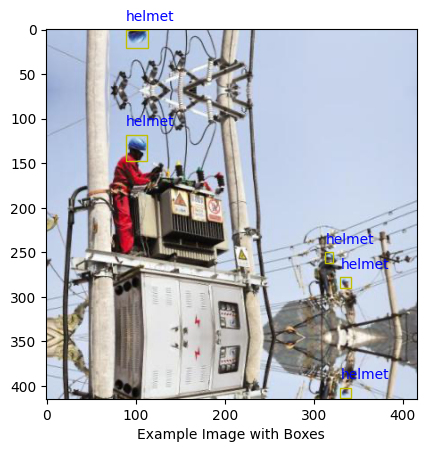

In [14]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    boxes = [] # here boxes is a list of dictionaries

    for obj in root.findall('.object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append({'name': name, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})

    return boxes

def plot_image_with_boxes(image_path, annotation_boxes):
    # Read the image
    image = Image.open(image_path)

    # Plot the image
    plt.imshow(image)

    # Plot the bounding boxes
    ax = plt.gca()
    for box in annotation_boxes:

        xmin, ymin, xmax, ymax = box['xmin'], box['ymin'], box['xmax'], box['ymax']
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='y', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin - 10, box['name'], color='b')
        plt.xlabel('Example Image with Boxes')

    plt.show()

# Example usage

image_path = "/kaggle/input/hard-hat-detection/images/hard_hat_workers5.png"
xml_file = "/kaggle/input/hard-hat-detection/annotations/hard_hat_workers5.xml"

annotation_boxes = parse_xml(xml_file)
'''
if want to print a particular class only.
list1=[]
for dict in annotation_boxes:
    if dict['name']== 'head':
      list1.append(dict)
list1
'''
plot_image_with_boxes(image_path, annotation_boxes)


# Declaring & Instantiating Model Architecture
# Using Resnet50 Backbone

In [15]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [16]:
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]

# define the optimizer & scheduler,

# Generally Rule of Thumb is to Use SGD+Momentum Or Adam with a Annealing Learning Rate Scheduler.

# (this is the simple optimizer you can use other optimizer with callbacks for complex dataset)

# taking mostly default values for a possible optimal solution.
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.5,last_epoch=-1)

# Note:- Here, I also tried with Adam with larger no. of epochs, but it comes out to be that SGD works better than Adam on this specific task.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 165MB/s]  


In [17]:
# function for running training iterations
from tqdm import tqdm

def train(train_data_loader, model):
    print('Training...')
    global train_itr
    global train_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    # criterion = torch.nn.BCELoss(size_average=True)

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad() #####
        images, targets = data #####

        images = list(image.to(DEVICE) for image in images) #####
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets] #####

        loss_dict = model(images, targets) #####
        losses = sum(loss for loss in loss_dict.values()) #####
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward() #####
        optimizer.step() #####
        train_itr += 1 #####

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [18]:
# The validation function returns a similar list containing the loss values
# for all the completed iterations

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating...')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [19]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss

    def __call__(self, current_valid_loss, epoch, model, optimizer, scheduler):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss:.3f}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                }, '/kaggle/working/savedmodel/best_model.pth')


# function to save the model after each epoch and after training ends
def save_model(epoch, model, optimizer, scheduler):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                }, '/kaggle/working/savedmodel/last_model.pth')
epoch=0

In [21]:
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# train and validation loss lists to store loss values of all
# iterations till end and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# initialize SaveBestModel class
save_best_model = SaveBestModel()

NUM_EPOCHS = 16 # number of epochs to train for

# start the training epochs
for epoch in range(epoch, NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)

    print(f'Current Learning Rate: {scheduler.get_last_lr()}') # this prints the lr used in training that specific epoch
    scheduler.step()

    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")

    # save the best model till now if we have the least loss in the current epoch
    save_best_model(val_loss_hist.value, epoch, model, optimizer, scheduler) # it will call the in-built __call__ function.
    # when you create an instance of a Class defined with __call__ func. also
    # you can directly call the __call__ func. using only the instance name
    # instance = Class(); instance(a,b) it is subsitute for instance.call(a,b)

    # save the current epoch model
    save_model(epoch, model, optimizer, scheduler)

    # save is done after scheduler.step()
    # as info. related to scheduler is saved in terms of steps, if saved before using scheduler.step(), it would cause training one more epoch
    # in a specific lr, here step size is 5, so when resumed training it will train one more epoch on that lr causing 6 to train using that
    # particular lr, which will be wrong.



EPOCH 1 of 16
Training...


Loss: 0.4514: 100%|██████████| 1000/1000 [14:39<00:00,  1.14it/s]


Validating...


Loss: 0.5060: 100%|██████████| 125/125 [00:49<00:00,  2.53it/s]


Current Learning Rate: [0.01]
Epoch #1 train loss: 0.588
Epoch #1 validation loss: 0.549

Best validation loss: 0.549

Saving best model for epoch: 1


EPOCH 2 of 16
Training...


Loss: 0.4043: 100%|██████████| 1000/1000 [14:42<00:00,  1.13it/s]


Validating...


Loss: 0.4598: 100%|██████████| 125/125 [00:49<00:00,  2.52it/s]


Current Learning Rate: [0.01]
Epoch #2 train loss: 0.530
Epoch #2 validation loss: 0.541

Best validation loss: 0.541

Saving best model for epoch: 2


EPOCH 3 of 16
Training...


Loss: 0.2195: 100%|██████████| 1000/1000 [14:40<00:00,  1.14it/s]


Validating...


Loss: 0.4008: 100%|██████████| 125/125 [00:49<00:00,  2.52it/s]


Current Learning Rate: [0.01]
Epoch #3 train loss: 0.504
Epoch #3 validation loss: 0.511

Best validation loss: 0.511

Saving best model for epoch: 3


EPOCH 4 of 16
Training...


Loss: 0.4326: 100%|██████████| 1000/1000 [14:40<00:00,  1.14it/s]


Validating...


Loss: 0.4828: 100%|██████████| 125/125 [00:49<00:00,  2.51it/s]


Current Learning Rate: [0.01]
Epoch #4 train loss: 0.472
Epoch #4 validation loss: 0.502

Best validation loss: 0.502

Saving best model for epoch: 4


EPOCH 5 of 16
Training...


Loss: 0.6285: 100%|██████████| 1000/1000 [14:37<00:00,  1.14it/s]


Validating...


Loss: 0.3830: 100%|██████████| 125/125 [00:49<00:00,  2.53it/s]


Current Learning Rate: [0.01]
Epoch #5 train loss: 0.461
Epoch #5 validation loss: 0.483

Best validation loss: 0.483

Saving best model for epoch: 5


EPOCH 6 of 16
Training...


Loss: 0.4053: 100%|██████████| 1000/1000 [14:40<00:00,  1.14it/s]


Validating...


Loss: 0.3467: 100%|██████████| 125/125 [00:49<00:00,  2.52it/s]


Current Learning Rate: [0.005]
Epoch #6 train loss: 0.399
Epoch #6 validation loss: 0.447

Best validation loss: 0.447

Saving best model for epoch: 6


EPOCH 7 of 16
Training...


Loss: 0.1706: 100%|██████████| 1000/1000 [14:39<00:00,  1.14it/s]


Validating...


Loss: 0.3852: 100%|██████████| 125/125 [00:49<00:00,  2.53it/s]


Current Learning Rate: [0.005]
Epoch #7 train loss: 0.376
Epoch #7 validation loss: 0.450

EPOCH 8 of 16
Training...


Loss: 0.1811: 100%|██████████| 1000/1000 [14:40<00:00,  1.14it/s]


Validating...


Loss: 0.3528: 100%|██████████| 125/125 [00:49<00:00,  2.52it/s]


Current Learning Rate: [0.005]
Epoch #8 train loss: 0.357
Epoch #8 validation loss: 0.431

Best validation loss: 0.431

Saving best model for epoch: 8


EPOCH 9 of 16
Training...


Loss: 0.3161:   7%|▋         | 73/1000 [01:04<13:38,  1.13it/s]


KeyboardInterrupt: 

# Loading The Model For Inference
# (Or For Training Resumption)

***For Training Resumption***

In [22]:
# load the last model and trained weights
# Before executing this, execute the Model Architecture section

model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('/kaggle/working/savedmodel/last_model.pth', map_location=DEVICE)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch= checkpoint['epoch']

model.to(DEVICE)  # since, we'll be using this to resume training, so it'll again be loaded in training mode,(not in EVAL mode)!
print(f'Successfully Loaded The Last Trained Model, achieved on Epoch {epoch}')

Successfully Loaded The Last Trained Model, achieved on Epoch 8


***For Taking Inference***

In [23]:
# load the best model and trained weights
# Before executing this, execute the Model Architecture section

model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('/kaggle/working/savedmodel/best_model.pth', map_location=DEVICE)

model.load_state_dict(checkpoint['model_state_dict'])

epoch= checkpoint['epoch']

model.to(DEVICE).eval()  # will be taking inference, so model should be put in EVAL mode.
print(f'Successfully Loaded The Best Model, achieved on Epoch {epoch}')

Successfully Loaded The Best Model, achieved on Epoch 8


# Analysis & Visualization of Predictions

In [24]:
# function to get actual bounding boxes & labels for the given image, which takes image_path
# & returns bbox coordinates & labels/class_names
def get_box_lbl(img_path):
    annot_filepath = os.path.join(Path(img_path).parent.parent,'annotations', Path(img_path).parts[-1][:-4] + '.xml')
    print(annot_filepath)
    boxes, labels = [], []
    root = ET.parse(annot_filepath).getroot()

    # extracting box coordinates from xml annotations
    for member in root.findall('object'):
        # map the current object name to classes to get the label index
        labels.append(CLASS_NAME.index(member.find('name').text))

        # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
        xmin = int(member.find('bndbox').find('xmin').text)
        ymin = int(member.find('bndbox').find('ymin').text)
        xmax = int(member.find('bndbox').find('xmax').text)
        ymax = int(member.find('bndbox').find('ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])

    return boxes, labels

In [25]:
# foll are various func to draw predicted bounding boxes & labels
import matplotlib.patches as patches, numpy as np

def img_show(img, ax = None, figsize=(16,8)):
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.tick_top()
    ax.imshow(img)
    return ax

def draw_box(ax, bb, lbl):
    if lbl=='helmet': # 1=helmet
        color_lbl='yellow'
    elif lbl=='head': # 2=head
        color_lbl='red'
    else:
        color_lbl='blue'

    rect = patches.Rectangle(
        (int(bb[0]),int(bb[1])), int(bb[2])-int(bb[0]), int(bb[3])-int(bb[1]),
        fill=False, edgecolor=color_lbl, lw=2
    )
    ax.add_patch(rect)


def plot_pred(ax, tboxes, tlbls):
    for i in range(len(tboxes)):
        draw_box(ax, tboxes[i], tlbls[i])

def plot_act(img, boxes, ax=None, figsize=(16,8)):
    ax = img_show(img, ax=ax)
    for i in range(len(boxes)):
        rect = patches.Rectangle(
            (int(boxes[i][0]),int(boxes[i][1])), int(boxes[i][2])-int(boxes[i][0]), int(boxes[i][3])-int(boxes[i][1]),
            fill=False, edgecolor='green', lw=2
            )
        ax.add_patch(rect)
    return ax

In [26]:
def compare_prediction_with_actual(image_path, image_name, detection_threshold):
    image = plt.imread(image_path+"/"+image_name)
    img = image.copy()
    input_image=(image_path+"/"+image_name)
    # bring color channels to front
    img = np.transpose(img, (2, 0, 1)).astype(np.float32)

    # convert to tensor; tensor([  3., 416., 416.], device='cuda:0')
    img = torch.tensor(img, dtype=torch.float).cuda() #gpu enabled

    # add batch dimension
    img = torch.unsqueeze(img, 0)
    with torch.no_grad(): #forward pass
        outputs = model(img.to(DEVICE))


    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    ''' outputs is a list containing dictionaries. Each dictionary represents the output of the model for a batch of data.
    The new key-value pairs with values on the CPU are collected into a new dictionary, and this dictionary is added to the list.
    moving to CPU bcoz working with visualizations or post-processing steps that may not be available on the GPU'''

    # draw actual bounding boxes (to compare with predicted boxes)
    act_box, act_lbl = get_box_lbl(input_image) #get actual boxes & labels
    ax = plot_act(image, act_box)

    p_voc_format_act_box={}
    p_voc_format_act_box[image_name] = {'boxes':act_box, 'labels': act_lbl}


    print(f"Actual number of Boxes: {len(act_box)}")
    print(f"Actual boxes: {act_box}")

    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) > 0:
        boxes = outputs[0]['boxes'].data.numpy() #converting tensor coordinates to numpy array
        scores = outputs[0]['scores'].data.numpy()
        lbls = outputs[0]['labels'].data.numpy()

        print(f"Detection Threshold: {detection_threshold}")
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores > detection_threshold].astype(np.int32)

        lbls = lbls[scores > detection_threshold].astype(np.int32)
        pred_boxes = boxes.copy()

        scores = scores[scores > detection_threshold].astype(np.float32)
        # Returning only the boxes and scores which are above the detection_threshold
        p_voc_format_pred_box = {}
        p_voc_format_pred_box[image_name] = {'boxes':boxes,'scores':scores,'labels': lbls}

        print(f"Predicted number of Boxes: {len(pred_boxes)}")
        print(f"Predicted boxes: {pred_boxes}")
        # get all the predicited class names
        pred_class = [CLASS_NAME[i] for i in lbls]

        # draw predicted boxes (to compare with actuals)
        plot_pred(ax, pred_boxes, pred_class)
    print("ACTUAL: GREEN      PREDICTED : YELLOW || RED || BLUE")
    return p_voc_format_act_box, p_voc_format_pred_box

/kaggle/working/test/annotations/hard_hat_workers539.xml
Actual number of Boxes: 2
Actual boxes: [[188, 142, 217, 169], [21, 201, 40, 222]]
Detection Threshold: 0.8
Predicted number of Boxes: 14
Predicted boxes: [[187 141 215 163]
 [108   0 128  26]
 [350   0 367  16]
 [172   0 193  16]
 [232 284 258 318]
 [395 311 411 331]
 [187 198 208 216]
 [ 35 222  53 242]
 [110 109 127 129]
 [ 93 216 111 232]
 [212 296 233 315]
 [ 92 335 108 355]
 [186 136 206 177]
 [337 329 358 358]]
ACTUAL: GREEN      PREDICTED : YELLOW || RED || BLUE


({'hard_hat_workers539.png': {'boxes': [[188, 142, 217, 169],
    [21, 201, 40, 222]],
   'labels': [1, 1]}},
 {'hard_hat_workers539.png': {'boxes': array([[187, 141, 215, 163],
          [108,   0, 128,  26],
          [350,   0, 367,  16],
          [172,   0, 193,  16],
          [232, 284, 258, 318],
          [395, 311, 411, 331],
          [187, 198, 208, 216],
          [ 35, 222,  53, 242],
          [110, 109, 127, 129],
          [ 93, 216, 111, 232],
          [212, 296, 233, 315],
          [ 92, 335, 108, 355],
          [186, 136, 206, 177],
          [337, 329, 358, 358]], dtype=int32),
   'scores': array([0.99997556, 0.99505025, 0.99453896, 0.99346304, 0.98589665,
          0.98549277, 0.97902465, 0.9578853 , 0.9398693 , 0.92004997,
          0.9070851 , 0.88202673, 0.88013566, 0.82222414], dtype=float32),
   'labels': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)}})

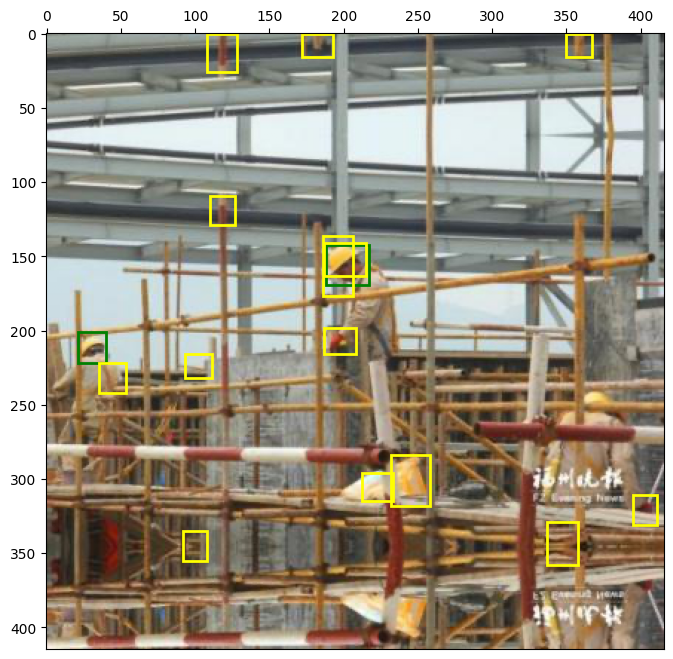

In [29]:
#validation of the bounding box
import random
image_ref = ("/kaggle/working/val/images/hard_hat_workers123.png")
#it is just for reference, input_image

image_path = "/kaggle/working/test/images"

file_names = os.listdir(image_path)
image_name = random.choice(file_names)

compare_prediction_with_actual(image_path, image_name, 0.8)
# if you run this cell on CPU, you will encounter an error as it is made to run on GPU.
# if you still want to run on CPU, just remove .cuda() from this line in the funtion defn.:
# img = torch.tensor(img, dtype=torch.float).cuda() #gpu enabled
# similarly, you have to do this for pred box too.

In [30]:
def pred_box(image_path, image_name, detection_threshold):
    image = plt.imread(image_path+"/"+image_name)
    img = image.copy()
    input_image=(image_path+"/"+image_name)
    # bring color channels to front
    img = np.transpose(img, (2, 0, 1)).astype(np.float32)

    # convert to tensor; tensor([  3., 416., 416.], device='cuda:0')
    img = torch.tensor(img, dtype=torch.float).cuda() #gpu enabled

    # add batch dimension
    img = torch.unsqueeze(img, 0)
    with torch.no_grad(): #forward pass
        outputs = model(img.to(DEVICE))

    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    ''' outputs is a list containing dictionaries. Each dictionary represents the output of the model for a batch of data.
    The new key-value pairs with values on the CPU are collected into a new dictionary, and this dictionary is added to the list.
    moving to CPU bcoz working with visualizations or post-processing steps that may not be available on the GPU'''

    # draw actual bounding boxes (to compare with predicted boxes)
    act_box, act_lbl = get_box_lbl(input_image) #get actual boxes & labels

    #ax = plot_act(image, act_box)

    p_voc_format_act_box={}
    p_voc_format_act_box[image_name] = {'boxes':act_box, 'labels': act_lbl}

    #print(f"Actual number of Boxes: {len(act_box)}")
    #print(f"Actual boxes: {act_box}")

    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) > 0:
        boxes = outputs[0]['boxes'].data.numpy() #converting tensor coordinates to numpy array
        scores = outputs[0]['scores'].data.numpy()
        lbls = outputs[0]['labels'].data.numpy()

        #print(f"Detection Threshold: {detection_threshold}")
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores > detection_threshold].astype(np.int32)

        lbls = lbls[scores > detection_threshold].astype(np.int32)
        #pred_boxes = boxes.copy()

        scores = scores[scores > detection_threshold].astype(np.float32)

        # Returning only the boxes and scores which are above the detection_threshold
        p_voc_format_pred_box = {}
        p_voc_format_pred_box[image_name] = {'boxes':boxes,'scores':scores, 'labels': lbls}

    return p_voc_format_act_box, p_voc_format_pred_box

# **Evaluating the Model**
# By Precision & Recall Metrics
$Precision = \frac{True Positives}{True Positives + False Positives}$

\
$Recall = \frac{True Positives}{True Positives + False Negatives}$

#Hyperparameters

1.   **IoU Threshold = 0.5**
2.   **Confidence Score Threshold = 0.8**



In [31]:
import numpy as np

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.

    Parameters:
    - box1, box2: Bounding boxes in the format [x_min, y_min, x_max, y_max].

    Returns:
    - IoU: Intersection over Union value.
    """

    # Calculate the coordinates of the intersection rectangle
    x_min_inter = max(box1[0], box2[0])
    y_min_inter = max(box1[1], box2[1])
    x_max_inter = min(box1[2], box2[2])
    y_max_inter = min(box1[3], box2[3])

    # Calculate the area of the intersection rectangle
    area_inter = max(0, x_max_inter - x_min_inter + 1) * max(0, y_max_inter - y_min_inter + 1)

    # Calculate the area of both bounding boxes
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calculate IoU
    iou = area_inter / float(area_box1 + area_box2 - area_inter)

    return iou

In [32]:
# !(taking one image at a time) & calculating tp,fp & fn for each class
# & accumulating them to list final to calculate precision & recall for each class

# targets_single_image = {...}  # Dictionary containing all actual bounding boxes and labels of a single image
# predictions_single_image = {...}  # Dictionary containing all predicted bounding boxes and labels of a single image

#  we are then separating actual & predicted boxes class-wise and then taking the tp,fp,fn contributions for that specific class

def calculate_values_per_class(targets_single_image, predictions_single_image, num_classes, iou_threshold=0.5):
    list=[]

    for class_idx in range(1, num_classes):  # excluding background class (0)
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        true_boxes, pred_boxes =[], []

        for image_name, pred_data in predictions_single_image.items(): #getting same label pred boxes
          for idx,lbl in enumerate(pred_data['labels']):
            if(lbl==class_idx):
              pred_boxes.append(pred_data['boxes'][idx])

        for image_name, true_data in targets_single_image.items(): #getting same label actual boxes
          for idx,lbl in enumerate(true_data['labels']):
            if(lbl==class_idx):
              true_boxes.append(true_data['boxes'][idx])


        matched_preds = [False] * len(pred_boxes)
        matched_targets = [False] * len(true_boxes)

        for i, pred_box in enumerate(pred_boxes):  #checking whether the predicted box is tp or fp
          for j, true_box in enumerate(true_boxes): # by calculating IoU with actual boxes.
            iou = calculate_iou(pred_box, true_box)
            if iou >= iou_threshold:
             true_positives += 1
             matched_preds[i] = True
             matched_targets[j] = True

        false_positives += len(pred_boxes) - sum(matched_preds)
        false_negatives += len(true_boxes) - sum(matched_targets)
        list1=[true_positives, false_positives, false_negatives]
        list.append(list1)   # finally, sending them list of (#tp,#fp,#fn) to the acuumulator of that class

    # similarly getting lists for all classes.
    return list

In [33]:
def calculate_precision_recall(list):
  precision_recall_dict={}
  for idx,element in tqdm(enumerate(list), total=len(list)):
    true_positives, false_positives, false_negatives = element
    precision_ = true_positives / (true_positives + false_positives + 1e-6)
    recall_ = true_positives / (true_positives + false_negatives + 1e-6)
    precision = round(precision_, 4)
    recall = round(recall_, 4)
    precision_recall_dict[f'Class {idx+1}'] = {'Precision': precision, 'Recall': recall}

  # Print the results
  print('\n')
  idx=1

  def caps(input_str):
    return input_str.upper()

  for class_name, metrics in precision_recall_dict.items():
    print(caps(CLASS_NAME[idx]))
    print(f"{class_name}: Precision = {metrics['Precision']:.4f}, Recall = {metrics['Recall']:.4f}")
    print()
    idx+=1

  return precision_recall_dict

In [36]:
list_final=  [[0,0,0],[0,0,0],[0,0,0]] # here each row represents the accumulator of each class.
# which are getting updated by every call of calculate_values_per_class func.

test_image_path = "/kaggle/working/test/images"
file_names = os.listdir(test_image_path)

iou_threshold = 0.5
CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
num_classes = len(CLASS_NAME)

for input_image in tqdm(file_names, total=len(file_names)):
  # here, we are taking detection threshold to be 0.8.
  # any detection having score below this will be discarded, i.e bbox with scores more than 0.93
  # will be shown, less than the threshold will not be shown
  act_box_single_image, pred_box_single_image = pred_box(test_image_path, input_image, 0.93)
  lists= calculate_values_per_class(act_box_single_image, pred_box_single_image, num_classes, iou_threshold)
  for idx,list in enumerate(lists):
    for i in range(3):
      list_final[idx][i] += list[i]

  0%|          | 2/500 [00:00<01:01,  8.07it/s]

/kaggle/working/test/annotations/hard_hat_workers4671.xml
/kaggle/working/test/annotations/hard_hat_workers4741.xml


  1%|          | 4/500 [00:00<00:56,  8.80it/s]

/kaggle/working/test/annotations/hard_hat_workers523.xml
/kaggle/working/test/annotations/hard_hat_workers4972.xml


  1%|          | 6/500 [00:00<00:54,  9.10it/s]

/kaggle/working/test/annotations/hard_hat_workers480.xml
/kaggle/working/test/annotations/hard_hat_workers4818.xml


  2%|▏         | 8/500 [00:00<00:54,  9.10it/s]

/kaggle/working/test/annotations/hard_hat_workers4745.xml
/kaggle/working/test/annotations/hard_hat_workers4701.xml


  2%|▏         | 10/500 [00:01<00:53,  9.10it/s]

/kaggle/working/test/annotations/hard_hat_workers4966.xml
/kaggle/working/test/annotations/hard_hat_workers4624.xml


  2%|▏         | 12/500 [00:01<00:53,  9.17it/s]

/kaggle/working/test/annotations/hard_hat_workers506.xml
/kaggle/working/test/annotations/hard_hat_workers4826.xml


  3%|▎         | 14/500 [00:01<00:52,  9.29it/s]

/kaggle/working/test/annotations/hard_hat_workers512.xml
/kaggle/working/test/annotations/hard_hat_workers4634.xml


  3%|▎         | 16/500 [00:01<00:51,  9.32it/s]

/kaggle/working/test/annotations/hard_hat_workers4988.xml
/kaggle/working/test/annotations/hard_hat_workers519.xml


  4%|▎         | 18/500 [00:01<00:51,  9.29it/s]

/kaggle/working/test/annotations/hard_hat_workers4911.xml
/kaggle/working/test/annotations/hard_hat_workers542.xml


  4%|▍         | 20/500 [00:02<00:54,  8.82it/s]

/kaggle/working/test/annotations/hard_hat_workers4783.xml
/kaggle/working/test/annotations/hard_hat_workers4767.xml


  4%|▍         | 22/500 [00:02<00:51,  9.19it/s]

/kaggle/working/test/annotations/hard_hat_workers4906.xml
/kaggle/working/test/annotations/hard_hat_workers4643.xml


  5%|▍         | 24/500 [00:02<00:51,  9.33it/s]

/kaggle/working/test/annotations/hard_hat_workers4717.xml
/kaggle/working/test/annotations/hard_hat_workers471.xml


  5%|▌         | 26/500 [00:02<00:51,  9.15it/s]

/kaggle/working/test/annotations/hard_hat_workers4836.xml
/kaggle/working/test/annotations/hard_hat_workers546.xml


  6%|▌         | 28/500 [00:03<00:51,  9.17it/s]

/kaggle/working/test/annotations/hard_hat_workers4867.xml
/kaggle/working/test/annotations/hard_hat_workers4617.xml


  6%|▌         | 30/500 [00:03<00:51,  9.09it/s]

/kaggle/working/test/annotations/hard_hat_workers4721.xml
/kaggle/working/test/annotations/hard_hat_workers4680.xml


  6%|▋         | 32/500 [00:03<00:51,  9.13it/s]

/kaggle/working/test/annotations/hard_hat_workers4890.xml
/kaggle/working/test/annotations/hard_hat_workers4633.xml


  7%|▋         | 34/500 [00:03<00:49,  9.33it/s]

/kaggle/working/test/annotations/hard_hat_workers4956.xml
/kaggle/working/test/annotations/hard_hat_workers4771.xml


  7%|▋         | 36/500 [00:03<00:50,  9.28it/s]

/kaggle/working/test/annotations/hard_hat_workers4695.xml
/kaggle/working/test/annotations/hard_hat_workers4938.xml


  8%|▊         | 38/500 [00:04<00:49,  9.34it/s]

/kaggle/working/test/annotations/hard_hat_workers4760.xml
/kaggle/working/test/annotations/hard_hat_workers4937.xml


  8%|▊         | 40/500 [00:04<00:50,  9.18it/s]

/kaggle/working/test/annotations/hard_hat_workers504.xml
/kaggle/working/test/annotations/hard_hat_workers4875.xml


  8%|▊         | 42/500 [00:04<00:50,  9.00it/s]

/kaggle/working/test/annotations/hard_hat_workers488.xml
/kaggle/working/test/annotations/hard_hat_workers4653.xml


  9%|▉         | 44/500 [00:04<00:49,  9.13it/s]

/kaggle/working/test/annotations/hard_hat_workers4755.xml
/kaggle/working/test/annotations/hard_hat_workers4805.xml


  9%|▉         | 46/500 [00:05<00:49,  9.08it/s]

/kaggle/working/test/annotations/hard_hat_workers4884.xml
/kaggle/working/test/annotations/hard_hat_workers4716.xml


 10%|▉         | 48/500 [00:05<00:49,  9.09it/s]

/kaggle/working/test/annotations/hard_hat_workers4658.xml
/kaggle/working/test/annotations/hard_hat_workers4973.xml


 10%|█         | 50/500 [00:05<00:48,  9.24it/s]

/kaggle/working/test/annotations/hard_hat_workers4664.xml
/kaggle/working/test/annotations/hard_hat_workers4697.xml


 10%|█         | 52/500 [00:05<00:48,  9.23it/s]

/kaggle/working/test/annotations/hard_hat_workers4844.xml
/kaggle/working/test/annotations/hard_hat_workers4666.xml


 11%|█         | 54/500 [00:05<00:48,  9.14it/s]

/kaggle/working/test/annotations/hard_hat_workers54.xml
/kaggle/working/test/annotations/hard_hat_workers4904.xml


 11%|█         | 56/500 [00:06<00:47,  9.37it/s]

/kaggle/working/test/annotations/hard_hat_workers4877.xml
/kaggle/working/test/annotations/hard_hat_workers4679.xml


 12%|█▏        | 58/500 [00:06<00:47,  9.37it/s]

/kaggle/working/test/annotations/hard_hat_workers4814.xml
/kaggle/working/test/annotations/hard_hat_workers500.xml


 12%|█▏        | 60/500 [00:06<00:47,  9.21it/s]

/kaggle/working/test/annotations/hard_hat_workers4820.xml
/kaggle/working/test/annotations/hard_hat_workers4659.xml


 12%|█▏        | 62/500 [00:06<00:47,  9.17it/s]

/kaggle/working/test/annotations/hard_hat_workers4809.xml
/kaggle/working/test/annotations/hard_hat_workers4921.xml


 13%|█▎        | 64/500 [00:06<00:47,  9.17it/s]

/kaggle/working/test/annotations/hard_hat_workers4936.xml
/kaggle/working/test/annotations/hard_hat_workers4916.xml


 13%|█▎        | 66/500 [00:07<00:46,  9.28it/s]

/kaggle/working/test/annotations/hard_hat_workers52.xml
/kaggle/working/test/annotations/hard_hat_workers4935.xml


 14%|█▎        | 68/500 [00:07<00:46,  9.33it/s]

/kaggle/working/test/annotations/hard_hat_workers4729.xml
/kaggle/working/test/annotations/hard_hat_workers4654.xml


 14%|█▍        | 70/500 [00:07<00:46,  9.20it/s]

/kaggle/working/test/annotations/hard_hat_workers544.xml
/kaggle/working/test/annotations/hard_hat_workers4931.xml


 14%|█▍        | 72/500 [00:07<00:46,  9.25it/s]

/kaggle/working/test/annotations/hard_hat_workers4655.xml
/kaggle/working/test/annotations/hard_hat_workers4983.xml


 15%|█▍        | 74/500 [00:08<00:46,  9.21it/s]

/kaggle/working/test/annotations/hard_hat_workers4622.xml
/kaggle/working/test/annotations/hard_hat_workers4880.xml


 15%|█▌        | 76/500 [00:08<00:46,  9.12it/s]

/kaggle/working/test/annotations/hard_hat_workers503.xml
/kaggle/working/test/annotations/hard_hat_workers4971.xml


 16%|█▌        | 78/500 [00:08<00:46,  9.05it/s]

/kaggle/working/test/annotations/hard_hat_workers4989.xml
/kaggle/working/test/annotations/hard_hat_workers4866.xml


 16%|█▌        | 80/500 [00:08<00:45,  9.16it/s]

/kaggle/working/test/annotations/hard_hat_workers467.xml
/kaggle/working/test/annotations/hard_hat_workers4885.xml


 16%|█▋        | 82/500 [00:08<00:46,  8.97it/s]

/kaggle/working/test/annotations/hard_hat_workers4964.xml
/kaggle/working/test/annotations/hard_hat_workers509.xml


 17%|█▋        | 84/500 [00:09<00:45,  9.09it/s]

/kaggle/working/test/annotations/hard_hat_workers4657.xml
/kaggle/working/test/annotations/hard_hat_workers505.xml


 17%|█▋        | 86/500 [00:09<00:44,  9.30it/s]

/kaggle/working/test/annotations/hard_hat_workers4979.xml
/kaggle/working/test/annotations/hard_hat_workers4939.xml


 18%|█▊        | 88/500 [00:09<00:44,  9.21it/s]

/kaggle/working/test/annotations/hard_hat_workers4851.xml
/kaggle/working/test/annotations/hard_hat_workers4856.xml


 18%|█▊        | 90/500 [00:09<00:43,  9.43it/s]

/kaggle/working/test/annotations/hard_hat_workers508.xml
/kaggle/working/test/annotations/hard_hat_workers4925.xml


 18%|█▊        | 92/500 [00:10<00:42,  9.59it/s]

/kaggle/working/test/annotations/hard_hat_workers4621.xml
/kaggle/working/test/annotations/hard_hat_workers536.xml


 19%|█▉        | 94/500 [00:10<00:43,  9.35it/s]

/kaggle/working/test/annotations/hard_hat_workers535.xml
/kaggle/working/test/annotations/hard_hat_workers4926.xml


 19%|█▉        | 96/500 [00:10<00:44,  9.03it/s]

/kaggle/working/test/annotations/hard_hat_workers4959.xml
/kaggle/working/test/annotations/hard_hat_workers4900.xml


 20%|█▉        | 98/500 [00:10<00:44,  9.06it/s]

/kaggle/working/test/annotations/hard_hat_workers4985.xml
/kaggle/working/test/annotations/hard_hat_workers4914.xml


 20%|██        | 100/500 [00:10<00:44,  9.01it/s]

/kaggle/working/test/annotations/hard_hat_workers4753.xml
/kaggle/working/test/annotations/hard_hat_workers4963.xml


 20%|██        | 102/500 [00:11<00:43,  9.15it/s]

/kaggle/working/test/annotations/hard_hat_workers4961.xml
/kaggle/working/test/annotations/hard_hat_workers4846.xml


 21%|██        | 104/500 [00:11<00:43,  9.17it/s]

/kaggle/working/test/annotations/hard_hat_workers4702.xml
/kaggle/working/test/annotations/hard_hat_workers4627.xml


 21%|██        | 106/500 [00:11<00:43,  9.01it/s]

/kaggle/working/test/annotations/hard_hat_workers476.xml
/kaggle/working/test/annotations/hard_hat_workers4782.xml


 22%|██▏       | 108/500 [00:11<00:42,  9.20it/s]

/kaggle/working/test/annotations/hard_hat_workers4974.xml
/kaggle/working/test/annotations/hard_hat_workers4754.xml


 22%|██▏       | 110/500 [00:12<00:43,  9.07it/s]

/kaggle/working/test/annotations/hard_hat_workers4955.xml
/kaggle/working/test/annotations/hard_hat_workers4718.xml


 22%|██▏       | 112/500 [00:12<00:43,  8.99it/s]

/kaggle/working/test/annotations/hard_hat_workers4706.xml
/kaggle/working/test/annotations/hard_hat_workers530.xml


 23%|██▎       | 114/500 [00:12<00:42,  8.98it/s]

/kaggle/working/test/annotations/hard_hat_workers4747.xml
/kaggle/working/test/annotations/hard_hat_workers4635.xml


 23%|██▎       | 116/500 [00:12<00:41,  9.24it/s]

/kaggle/working/test/annotations/hard_hat_workers4689.xml
/kaggle/working/test/annotations/hard_hat_workers4950.xml


 24%|██▎       | 118/500 [00:12<00:41,  9.29it/s]

/kaggle/working/test/annotations/hard_hat_workers4713.xml
/kaggle/working/test/annotations/hard_hat_workers4981.xml


 24%|██▍       | 120/500 [00:13<00:41,  9.23it/s]

/kaggle/working/test/annotations/hard_hat_workers4751.xml
/kaggle/working/test/annotations/hard_hat_workers477.xml


 24%|██▍       | 122/500 [00:13<00:40,  9.28it/s]

/kaggle/working/test/annotations/hard_hat_workers4732.xml
/kaggle/working/test/annotations/hard_hat_workers4667.xml


 25%|██▍       | 124/500 [00:13<00:41,  9.12it/s]

/kaggle/working/test/annotations/hard_hat_workers4738.xml
/kaggle/working/test/annotations/hard_hat_workers4882.xml


 25%|██▌       | 126/500 [00:13<00:40,  9.24it/s]

/kaggle/working/test/annotations/hard_hat_workers4723.xml
/kaggle/working/test/annotations/hard_hat_workers4775.xml


 26%|██▌       | 128/500 [00:13<00:39,  9.32it/s]

/kaggle/working/test/annotations/hard_hat_workers538.xml
/kaggle/working/test/annotations/hard_hat_workers5.xml


 26%|██▌       | 130/500 [00:14<00:39,  9.32it/s]

/kaggle/working/test/annotations/hard_hat_workers4951.xml
/kaggle/working/test/annotations/hard_hat_workers4746.xml


 26%|██▋       | 132/500 [00:14<00:38,  9.49it/s]

/kaggle/working/test/annotations/hard_hat_workers4860.xml
/kaggle/working/test/annotations/hard_hat_workers4898.xml


 27%|██▋       | 134/500 [00:14<00:38,  9.42it/s]

/kaggle/working/test/annotations/hard_hat_workers4759.xml
/kaggle/working/test/annotations/hard_hat_workers4742.xml


 27%|██▋       | 136/500 [00:14<00:38,  9.42it/s]

/kaggle/working/test/annotations/hard_hat_workers4934.xml
/kaggle/working/test/annotations/hard_hat_workers51.xml


 28%|██▊       | 138/500 [00:15<00:39,  9.19it/s]

/kaggle/working/test/annotations/hard_hat_workers463.xml
/kaggle/working/test/annotations/hard_hat_workers487.xml


 28%|██▊       | 140/500 [00:15<00:39,  9.18it/s]

/kaggle/working/test/annotations/hard_hat_workers4649.xml
/kaggle/working/test/annotations/hard_hat_workers4827.xml


 28%|██▊       | 142/500 [00:15<00:38,  9.19it/s]

/kaggle/working/test/annotations/hard_hat_workers4838.xml
/kaggle/working/test/annotations/hard_hat_workers4630.xml


 29%|██▉       | 144/500 [00:15<00:38,  9.31it/s]

/kaggle/working/test/annotations/hard_hat_workers4780.xml
/kaggle/working/test/annotations/hard_hat_workers4997.xml


 29%|██▉       | 146/500 [00:15<00:37,  9.46it/s]

/kaggle/working/test/annotations/hard_hat_workers4871.xml
/kaggle/working/test/annotations/hard_hat_workers4835.xml


 30%|██▉       | 148/500 [00:16<00:37,  9.40it/s]

/kaggle/working/test/annotations/hard_hat_workers4811.xml
/kaggle/working/test/annotations/hard_hat_workers4797.xml


 30%|███       | 150/500 [00:16<00:38,  9.19it/s]

/kaggle/working/test/annotations/hard_hat_workers4726.xml
/kaggle/working/test/annotations/hard_hat_workers540.xml


 30%|███       | 152/500 [00:16<00:38,  9.13it/s]

/kaggle/working/test/annotations/hard_hat_workers46.xml
/kaggle/working/test/annotations/hard_hat_workers4614.xml


 31%|███       | 154/500 [00:16<00:37,  9.19it/s]

/kaggle/working/test/annotations/hard_hat_workers4677.xml
/kaggle/working/test/annotations/hard_hat_workers4763.xml


 31%|███       | 156/500 [00:16<00:36,  9.53it/s]

/kaggle/working/test/annotations/hard_hat_workers4842.xml
/kaggle/working/test/annotations/hard_hat_workers50.xml


 32%|███▏      | 158/500 [00:17<00:36,  9.39it/s]

/kaggle/working/test/annotations/hard_hat_workers4901.xml
/kaggle/working/test/annotations/hard_hat_workers4943.xml


 32%|███▏      | 160/500 [00:17<00:35,  9.61it/s]

/kaggle/working/test/annotations/hard_hat_workers4714.xml
/kaggle/working/test/annotations/hard_hat_workers4945.xml


 32%|███▏      | 162/500 [00:17<00:35,  9.57it/s]

/kaggle/working/test/annotations/hard_hat_workers472.xml
/kaggle/working/test/annotations/hard_hat_workers4641.xml


 33%|███▎      | 164/500 [00:17<00:35,  9.45it/s]

/kaggle/working/test/annotations/hard_hat_workers4786.xml
/kaggle/working/test/annotations/hard_hat_workers4909.xml


 33%|███▎      | 166/500 [00:18<00:35,  9.43it/s]

/kaggle/working/test/annotations/hard_hat_workers522.xml
/kaggle/working/test/annotations/hard_hat_workers4919.xml


 34%|███▎      | 168/500 [00:18<00:35,  9.24it/s]

/kaggle/working/test/annotations/hard_hat_workers4869.xml
/kaggle/working/test/annotations/hard_hat_workers4957.xml


 34%|███▍      | 170/500 [00:18<00:34,  9.46it/s]

/kaggle/working/test/annotations/hard_hat_workers4720.xml
/kaggle/working/test/annotations/hard_hat_workers4865.xml


 34%|███▍      | 172/500 [00:18<00:34,  9.48it/s]

/kaggle/working/test/annotations/hard_hat_workers4854.xml
/kaggle/working/test/annotations/hard_hat_workers4831.xml


 35%|███▍      | 174/500 [00:18<00:34,  9.41it/s]

/kaggle/working/test/annotations/hard_hat_workers4715.xml
/kaggle/working/test/annotations/hard_hat_workers4822.xml


 35%|███▌      | 176/500 [00:19<00:34,  9.47it/s]

/kaggle/working/test/annotations/hard_hat_workers4907.xml
/kaggle/working/test/annotations/hard_hat_workers532.xml


 36%|███▌      | 178/500 [00:19<00:33,  9.53it/s]

/kaggle/working/test/annotations/hard_hat_workers4816.xml
/kaggle/working/test/annotations/hard_hat_workers4725.xml


 36%|███▌      | 179/500 [00:19<00:33,  9.51it/s]

/kaggle/working/test/annotations/hard_hat_workers490.xml
/kaggle/working/test/annotations/hard_hat_workers4785.xml


 36%|███▋      | 182/500 [00:19<00:33,  9.53it/s]

/kaggle/working/test/annotations/hard_hat_workers4735.xml
/kaggle/working/test/annotations/hard_hat_workers4917.xml


 37%|███▋      | 183/500 [00:19<00:33,  9.40it/s]

/kaggle/working/test/annotations/hard_hat_workers4965.xml
/kaggle/working/test/annotations/hard_hat_workers485.xml


 37%|███▋      | 185/500 [00:20<00:32,  9.63it/s]

/kaggle/working/test/annotations/hard_hat_workers4722.xml
/kaggle/working/test/annotations/hard_hat_workers4608.xml


 38%|███▊      | 188/500 [00:20<00:32,  9.57it/s]

/kaggle/working/test/annotations/hard_hat_workers4995.xml
/kaggle/working/test/annotations/hard_hat_workers4761.xml


 38%|███▊      | 190/500 [00:20<00:32,  9.54it/s]

/kaggle/working/test/annotations/hard_hat_workers478.xml
/kaggle/working/test/annotations/hard_hat_workers4801.xml


 38%|███▊      | 192/500 [00:20<00:32,  9.59it/s]

/kaggle/working/test/annotations/hard_hat_workers4670.xml
/kaggle/working/test/annotations/hard_hat_workers4886.xml


 39%|███▉      | 194/500 [00:20<00:32,  9.38it/s]

/kaggle/working/test/annotations/hard_hat_workers4889.xml
/kaggle/working/test/annotations/hard_hat_workers4661.xml


 39%|███▉      | 196/500 [00:21<00:33,  9.09it/s]

/kaggle/working/test/annotations/hard_hat_workers4646.xml
/kaggle/working/test/annotations/hard_hat_workers527.xml


 40%|███▉      | 198/500 [00:21<00:31,  9.45it/s]

/kaggle/working/test/annotations/hard_hat_workers517.xml
/kaggle/working/test/annotations/hard_hat_workers4990.xml


 40%|████      | 200/500 [00:21<00:31,  9.41it/s]

/kaggle/working/test/annotations/hard_hat_workers493.xml
/kaggle/working/test/annotations/hard_hat_workers4640.xml


 40%|████      | 202/500 [00:21<00:31,  9.42it/s]

/kaggle/working/test/annotations/hard_hat_workers464.xml
/kaggle/working/test/annotations/hard_hat_workers4739.xml


 41%|████      | 204/500 [00:22<00:31,  9.40it/s]

/kaggle/working/test/annotations/hard_hat_workers4852.xml
/kaggle/working/test/annotations/hard_hat_workers4698.xml


 41%|████      | 206/500 [00:22<00:30,  9.62it/s]

/kaggle/working/test/annotations/hard_hat_workers4848.xml
/kaggle/working/test/annotations/hard_hat_workers4757.xml


 42%|████▏     | 208/500 [00:22<00:30,  9.66it/s]

/kaggle/working/test/annotations/hard_hat_workers4976.xml
/kaggle/working/test/annotations/hard_hat_workers4879.xml


 42%|████▏     | 210/500 [00:22<00:30,  9.66it/s]

/kaggle/working/test/annotations/hard_hat_workers4752.xml
/kaggle/working/test/annotations/hard_hat_workers4991.xml


 42%|████▏     | 212/500 [00:22<00:30,  9.45it/s]

/kaggle/working/test/annotations/hard_hat_workers4941.xml
/kaggle/working/test/annotations/hard_hat_workers4930.xml


 43%|████▎     | 214/500 [00:23<00:30,  9.39it/s]

/kaggle/working/test/annotations/hard_hat_workers4883.xml
/kaggle/working/test/annotations/hard_hat_workers4607.xml


 43%|████▎     | 216/500 [00:23<00:30,  9.27it/s]

/kaggle/working/test/annotations/hard_hat_workers4845.xml
/kaggle/working/test/annotations/hard_hat_workers4922.xml


 43%|████▎     | 217/500 [00:23<00:30,  9.42it/s]

/kaggle/working/test/annotations/hard_hat_workers4813.xml
/kaggle/working/test/annotations/hard_hat_workers4843.xml


 44%|████▍     | 220/500 [00:23<00:29,  9.50it/s]

/kaggle/working/test/annotations/hard_hat_workers4605.xml
/kaggle/working/test/annotations/hard_hat_workers4804.xml


 44%|████▍     | 222/500 [00:23<00:29,  9.54it/s]

/kaggle/working/test/annotations/hard_hat_workers4650.xml
/kaggle/working/test/annotations/hard_hat_workers4870.xml


 45%|████▍     | 224/500 [00:24<00:28,  9.70it/s]

/kaggle/working/test/annotations/hard_hat_workers4946.xml
/kaggle/working/test/annotations/hard_hat_workers4897.xml


 45%|████▌     | 226/500 [00:24<00:28,  9.54it/s]

/kaggle/working/test/annotations/hard_hat_workers4734.xml
/kaggle/working/test/annotations/hard_hat_workers543.xml


 46%|████▌     | 228/500 [00:24<00:28,  9.58it/s]

/kaggle/working/test/annotations/hard_hat_workers4970.xml
/kaggle/working/test/annotations/hard_hat_workers4777.xml


 46%|████▌     | 230/500 [00:24<00:27,  9.73it/s]

/kaggle/working/test/annotations/hard_hat_workers461.xml
/kaggle/working/test/annotations/hard_hat_workers4858.xml


 46%|████▋     | 232/500 [00:24<00:27,  9.75it/s]

/kaggle/working/test/annotations/hard_hat_workers4663.xml
/kaggle/working/test/annotations/hard_hat_workers4982.xml
/kaggle/working/test/annotations/hard_hat_workers4840.xml


 47%|████▋     | 235/500 [00:25<00:27,  9.78it/s]

/kaggle/working/test/annotations/hard_hat_workers4996.xml
/kaggle/working/test/annotations/hard_hat_workers4730.xml


 47%|████▋     | 237/500 [00:25<00:27,  9.56it/s]

/kaggle/working/test/annotations/hard_hat_workers548.xml
/kaggle/working/test/annotations/hard_hat_workers497.xml


 48%|████▊     | 239/500 [00:25<00:27,  9.59it/s]

/kaggle/working/test/annotations/hard_hat_workers4810.xml
/kaggle/working/test/annotations/hard_hat_workers481.xml


 48%|████▊     | 241/500 [00:25<00:27,  9.43it/s]

/kaggle/working/test/annotations/hard_hat_workers4601.xml
/kaggle/working/test/annotations/hard_hat_workers514.xml


 49%|████▊     | 243/500 [00:26<00:27,  9.47it/s]

/kaggle/working/test/annotations/hard_hat_workers4688.xml
/kaggle/working/test/annotations/hard_hat_workers537.xml


 49%|████▉     | 245/500 [00:26<00:26,  9.60it/s]

/kaggle/working/test/annotations/hard_hat_workers4662.xml
/kaggle/working/test/annotations/hard_hat_workers4806.xml


 49%|████▉     | 247/500 [00:26<00:26,  9.52it/s]

/kaggle/working/test/annotations/hard_hat_workers545.xml
/kaggle/working/test/annotations/hard_hat_workers4765.xml


 50%|████▉     | 249/500 [00:26<00:25,  9.75it/s]

/kaggle/working/test/annotations/hard_hat_workers4669.xml
/kaggle/working/test/annotations/hard_hat_workers4933.xml


 50%|█████     | 250/500 [00:26<00:25,  9.64it/s]

/kaggle/working/test/annotations/hard_hat_workers4832.xml
/kaggle/working/test/annotations/hard_hat_workers4674.xml


 51%|█████     | 253/500 [00:27<00:25,  9.75it/s]

/kaggle/working/test/annotations/hard_hat_workers4878.xml
/kaggle/working/test/annotations/hard_hat_workers4656.xml


 51%|█████     | 255/500 [00:27<00:25,  9.75it/s]

/kaggle/working/test/annotations/hard_hat_workers499.xml
/kaggle/working/test/annotations/hard_hat_workers4792.xml


 51%|█████▏    | 257/500 [00:27<00:24,  9.78it/s]

/kaggle/working/test/annotations/hard_hat_workers4952.xml
/kaggle/working/test/annotations/hard_hat_workers4895.xml


 52%|█████▏    | 259/500 [00:27<00:24,  9.74it/s]

/kaggle/working/test/annotations/hard_hat_workers4958.xml
/kaggle/working/test/annotations/hard_hat_workers4644.xml


 52%|█████▏    | 261/500 [00:27<00:25,  9.56it/s]

/kaggle/working/test/annotations/hard_hat_workers511.xml
/kaggle/working/test/annotations/hard_hat_workers4823.xml


 53%|█████▎    | 263/500 [00:28<00:25,  9.39it/s]

/kaggle/working/test/annotations/hard_hat_workers4874.xml
/kaggle/working/test/annotations/hard_hat_workers4802.xml


 53%|█████▎    | 265/500 [00:28<00:24,  9.60it/s]

/kaggle/working/test/annotations/hard_hat_workers4960.xml
/kaggle/working/test/annotations/hard_hat_workers4693.xml


 53%|█████▎    | 267/500 [00:28<00:24,  9.64it/s]

/kaggle/working/test/annotations/hard_hat_workers475.xml
/kaggle/working/test/annotations/hard_hat_workers4762.xml


 54%|█████▍    | 269/500 [00:28<00:24,  9.37it/s]

/kaggle/working/test/annotations/hard_hat_workers491.xml
/kaggle/working/test/annotations/hard_hat_workers4733.xml


 54%|█████▍    | 271/500 [00:29<00:23,  9.56it/s]

/kaggle/working/test/annotations/hard_hat_workers4692.xml
/kaggle/working/test/annotations/hard_hat_workers4893.xml


 55%|█████▍    | 273/500 [00:29<00:23,  9.66it/s]

/kaggle/working/test/annotations/hard_hat_workers4626.xml
/kaggle/working/test/annotations/hard_hat_workers4638.xml


 55%|█████▌    | 275/500 [00:29<00:23,  9.67it/s]

/kaggle/working/test/annotations/hard_hat_workers4652.xml
/kaggle/working/test/annotations/hard_hat_workers4639.xml


 55%|█████▌    | 277/500 [00:29<00:22,  9.72it/s]

/kaggle/working/test/annotations/hard_hat_workers534.xml
/kaggle/working/test/annotations/hard_hat_workers4665.xml


 56%|█████▌    | 279/500 [00:29<00:23,  9.47it/s]

/kaggle/working/test/annotations/hard_hat_workers529.xml
/kaggle/working/test/annotations/hard_hat_workers4600.xml


 56%|█████▌    | 281/500 [00:30<00:22,  9.80it/s]

/kaggle/working/test/annotations/hard_hat_workers4929.xml
/kaggle/working/test/annotations/hard_hat_workers4905.xml
/kaggle/working/test/annotations/hard_hat_workers4927.xml


 57%|█████▋    | 284/500 [00:30<00:21,  9.88it/s]

/kaggle/working/test/annotations/hard_hat_workers4833.xml
/kaggle/working/test/annotations/hard_hat_workers53.xml


 57%|█████▋    | 286/500 [00:30<00:21,  9.85it/s]

/kaggle/working/test/annotations/hard_hat_workers4815.xml
/kaggle/working/test/annotations/hard_hat_workers4684.xml


 57%|█████▋    | 287/500 [00:30<00:21,  9.71it/s]

/kaggle/working/test/annotations/hard_hat_workers4888.xml
/kaggle/working/test/annotations/hard_hat_workers4948.xml
/kaggle/working/test/annotations/hard_hat_workers4731.xml


 58%|█████▊    | 291/500 [00:31<00:21,  9.80it/s]

/kaggle/working/test/annotations/hard_hat_workers4676.xml
/kaggle/working/test/annotations/hard_hat_workers4691.xml


 59%|█████▊    | 293/500 [00:31<00:21,  9.72it/s]

/kaggle/working/test/annotations/hard_hat_workers531.xml
/kaggle/working/test/annotations/hard_hat_workers460.xml


 59%|█████▉    | 294/500 [00:31<00:21,  9.53it/s]

/kaggle/working/test/annotations/hard_hat_workers4899.xml
/kaggle/working/test/annotations/hard_hat_workers4872.xml


 59%|█████▉    | 297/500 [00:31<00:21,  9.64it/s]

/kaggle/working/test/annotations/hard_hat_workers4610.xml
/kaggle/working/test/annotations/hard_hat_workers462.xml


 60%|█████▉    | 299/500 [00:31<00:21,  9.54it/s]

/kaggle/working/test/annotations/hard_hat_workers4978.xml
/kaggle/working/test/annotations/hard_hat_workers4770.xml


 60%|██████    | 301/500 [00:32<00:20,  9.52it/s]

/kaggle/working/test/annotations/hard_hat_workers468.xml
/kaggle/working/test/annotations/hard_hat_workers4903.xml


 61%|██████    | 303/500 [00:32<00:20,  9.43it/s]

/kaggle/working/test/annotations/hard_hat_workers4787.xml
/kaggle/working/test/annotations/hard_hat_workers4749.xml


 61%|██████    | 305/500 [00:32<00:20,  9.61it/s]

/kaggle/working/test/annotations/hard_hat_workers4853.xml
/kaggle/working/test/annotations/hard_hat_workers4967.xml


 61%|██████▏   | 307/500 [00:32<00:20,  9.62it/s]

/kaggle/working/test/annotations/hard_hat_workers520.xml
/kaggle/working/test/annotations/hard_hat_workers498.xml


 62%|██████▏   | 309/500 [00:32<00:20,  9.50it/s]

/kaggle/working/test/annotations/hard_hat_workers4750.xml
/kaggle/working/test/annotations/hard_hat_workers47.xml


 62%|██████▏   | 311/500 [00:33<00:19,  9.60it/s]

/kaggle/working/test/annotations/hard_hat_workers4690.xml
/kaggle/working/test/annotations/hard_hat_workers4855.xml


 63%|██████▎   | 314/500 [00:33<00:19,  9.78it/s]

/kaggle/working/test/annotations/hard_hat_workers4709.xml
/kaggle/working/test/annotations/hard_hat_workers4668.xml
/kaggle/working/test/annotations/hard_hat_workers4620.xml


 63%|██████▎   | 316/500 [00:33<00:19,  9.63it/s]

/kaggle/working/test/annotations/hard_hat_workers4632.xml
/kaggle/working/test/annotations/hard_hat_workers4613.xml


 64%|██████▎   | 318/500 [00:33<00:18,  9.62it/s]

/kaggle/working/test/annotations/hard_hat_workers4873.xml
/kaggle/working/test/annotations/hard_hat_workers48.xml


 64%|██████▍   | 320/500 [00:34<00:18,  9.60it/s]

/kaggle/working/test/annotations/hard_hat_workers4683.xml
/kaggle/working/test/annotations/hard_hat_workers4648.xml


 64%|██████▍   | 322/500 [00:34<00:18,  9.75it/s]

/kaggle/working/test/annotations/hard_hat_workers4673.xml
/kaggle/working/test/annotations/hard_hat_workers4791.xml


 65%|██████▍   | 324/500 [00:34<00:17,  9.85it/s]

/kaggle/working/test/annotations/hard_hat_workers4849.xml
/kaggle/working/test/annotations/hard_hat_workers4808.xml


 65%|██████▌   | 326/500 [00:34<00:17,  9.77it/s]

/kaggle/working/test/annotations/hard_hat_workers516.xml
/kaggle/working/test/annotations/hard_hat_workers4968.xml


 66%|██████▌   | 328/500 [00:34<00:17,  9.56it/s]

/kaggle/working/test/annotations/hard_hat_workers4774.xml
/kaggle/working/test/annotations/hard_hat_workers479.xml


 66%|██████▌   | 330/500 [00:35<00:17,  9.72it/s]

/kaggle/working/test/annotations/hard_hat_workers4623.xml
/kaggle/working/test/annotations/hard_hat_workers4887.xml


 66%|██████▌   | 331/500 [00:35<00:17,  9.73it/s]

/kaggle/working/test/annotations/hard_hat_workers4913.xml
/kaggle/working/test/annotations/hard_hat_workers4727.xml


 67%|██████▋   | 334/500 [00:35<00:17,  9.68it/s]

/kaggle/working/test/annotations/hard_hat_workers4609.xml
/kaggle/working/test/annotations/hard_hat_workers4924.xml


 67%|██████▋   | 336/500 [00:35<00:16,  9.78it/s]

/kaggle/working/test/annotations/hard_hat_workers4700.xml
/kaggle/working/test/annotations/hard_hat_workers4928.xml


 68%|██████▊   | 338/500 [00:35<00:16,  9.64it/s]

/kaggle/working/test/annotations/hard_hat_workers528.xml
/kaggle/working/test/annotations/hard_hat_workers4681.xml


 68%|██████▊   | 340/500 [00:36<00:16,  9.58it/s]

/kaggle/working/test/annotations/hard_hat_workers4947.xml
/kaggle/working/test/annotations/hard_hat_workers4606.xml


 68%|██████▊   | 342/500 [00:36<00:16,  9.67it/s]

/kaggle/working/test/annotations/hard_hat_workers4892.xml
/kaggle/working/test/annotations/hard_hat_workers4625.xml


 69%|██████▊   | 343/500 [00:36<00:16,  9.70it/s]

/kaggle/working/test/annotations/hard_hat_workers465.xml
/kaggle/working/test/annotations/hard_hat_workers4768.xml


 69%|██████▉   | 346/500 [00:36<00:15,  9.70it/s]

/kaggle/working/test/annotations/hard_hat_workers4712.xml
/kaggle/working/test/annotations/hard_hat_workers4828.xml


 70%|██████▉   | 348/500 [00:37<00:15,  9.62it/s]

/kaggle/working/test/annotations/hard_hat_workers4636.xml
/kaggle/working/test/annotations/hard_hat_workers4615.xml


 70%|██████▉   | 349/500 [00:37<00:15,  9.61it/s]

/kaggle/working/test/annotations/hard_hat_workers4660.xml
/kaggle/working/test/annotations/hard_hat_workers4772.xml


 70%|███████   | 352/500 [00:37<00:15,  9.70it/s]

/kaggle/working/test/annotations/hard_hat_workers4740.xml
/kaggle/working/test/annotations/hard_hat_workers4992.xml


 71%|███████   | 354/500 [00:37<00:15,  9.56it/s]

/kaggle/working/test/annotations/hard_hat_workers4839.xml
/kaggle/working/test/annotations/hard_hat_workers4944.xml


 71%|███████   | 355/500 [00:37<00:15,  9.57it/s]

/kaggle/working/test/annotations/hard_hat_workers515.xml
/kaggle/working/test/annotations/hard_hat_workers4850.xml


 71%|███████▏  | 357/500 [00:37<00:14,  9.67it/s]

/kaggle/working/test/annotations/hard_hat_workers4728.xml
/kaggle/working/test/annotations/hard_hat_workers4672.xml


 72%|███████▏  | 359/500 [00:38<00:14,  9.72it/s]

/kaggle/working/test/annotations/hard_hat_workers4881.xml
/kaggle/working/test/annotations/hard_hat_workers4999.xml


 72%|███████▏  | 362/500 [00:38<00:14,  9.81it/s]

/kaggle/working/test/annotations/hard_hat_workers4781.xml
/kaggle/working/test/annotations/hard_hat_workers541.xml


 73%|███████▎  | 364/500 [00:38<00:13,  9.81it/s]

/kaggle/working/test/annotations/hard_hat_workers4859.xml
/kaggle/working/test/annotations/hard_hat_workers4896.xml


 73%|███████▎  | 366/500 [00:38<00:13,  9.78it/s]

/kaggle/working/test/annotations/hard_hat_workers513.xml
/kaggle/working/test/annotations/hard_hat_workers4912.xml


 74%|███████▎  | 368/500 [00:39<00:13,  9.94it/s]

/kaggle/working/test/annotations/hard_hat_workers4604.xml
/kaggle/working/test/annotations/hard_hat_workers510.xml


 74%|███████▍  | 370/500 [00:39<00:13,  9.81it/s]

/kaggle/working/test/annotations/hard_hat_workers49.xml
/kaggle/working/test/annotations/hard_hat_workers4830.xml


 74%|███████▍  | 372/500 [00:39<00:13,  9.69it/s]

/kaggle/working/test/annotations/hard_hat_workers4737.xml
/kaggle/working/test/annotations/hard_hat_workers4825.xml


 75%|███████▍  | 374/500 [00:39<00:13,  9.65it/s]

/kaggle/working/test/annotations/hard_hat_workers4736.xml
/kaggle/working/test/annotations/hard_hat_workers501.xml


 75%|███████▌  | 376/500 [00:39<00:12,  9.89it/s]

/kaggle/working/test/annotations/hard_hat_workers4773.xml
/kaggle/working/test/annotations/hard_hat_workers4682.xml


 76%|███████▌  | 378/500 [00:40<00:12,  9.77it/s]

/kaggle/working/test/annotations/hard_hat_workers4876.xml
/kaggle/working/test/annotations/hard_hat_workers470.xml


 76%|███████▌  | 380/500 [00:40<00:12,  9.82it/s]

/kaggle/working/test/annotations/hard_hat_workers4793.xml
/kaggle/working/test/annotations/hard_hat_workers4790.xml


 76%|███████▋  | 382/500 [00:40<00:12,  9.79it/s]

/kaggle/working/test/annotations/hard_hat_workers4975.xml
/kaggle/working/test/annotations/hard_hat_workers507.xml


 77%|███████▋  | 384/500 [00:40<00:11,  9.72it/s]

/kaggle/working/test/annotations/hard_hat_workers4812.xml
/kaggle/working/test/annotations/hard_hat_workers4962.xml


 77%|███████▋  | 386/500 [00:40<00:11,  9.70it/s]

/kaggle/working/test/annotations/hard_hat_workers4612.xml
/kaggle/working/test/annotations/hard_hat_workers4769.xml


 78%|███████▊  | 388/500 [00:41<00:11,  9.74it/s]

/kaggle/working/test/annotations/hard_hat_workers466.xml
/kaggle/working/test/annotations/hard_hat_workers4710.xml


 78%|███████▊  | 390/500 [00:41<00:11,  9.78it/s]

/kaggle/working/test/annotations/hard_hat_workers4603.xml
/kaggle/working/test/annotations/hard_hat_workers4678.xml


 79%|███████▊  | 393/500 [00:41<00:10,  9.83it/s]

/kaggle/working/test/annotations/hard_hat_workers4953.xml
/kaggle/working/test/annotations/hard_hat_workers4861.xml
/kaggle/working/test/annotations/hard_hat_workers524.xml


 79%|███████▉  | 395/500 [00:41<00:10,  9.71it/s]

/kaggle/working/test/annotations/hard_hat_workers4980.xml
/kaggle/working/test/annotations/hard_hat_workers4748.xml


 79%|███████▉  | 397/500 [00:42<00:10,  9.55it/s]

/kaggle/working/test/annotations/hard_hat_workers4824.xml
/kaggle/working/test/annotations/hard_hat_workers4694.xml


 80%|███████▉  | 398/500 [00:42<00:10,  9.64it/s]

/kaggle/working/test/annotations/hard_hat_workers4794.xml
/kaggle/working/test/annotations/hard_hat_workers4940.xml


 80%|████████  | 401/500 [00:42<00:10,  9.76it/s]

/kaggle/working/test/annotations/hard_hat_workers4987.xml
/kaggle/working/test/annotations/hard_hat_workers4704.xml


 81%|████████  | 403/500 [00:42<00:09,  9.78it/s]

/kaggle/working/test/annotations/hard_hat_workers4611.xml
/kaggle/working/test/annotations/hard_hat_workers4778.xml
/kaggle/working/test/annotations/hard_hat_workers4800.xml


 81%|████████  | 406/500 [00:42<00:09,  9.84it/s]

/kaggle/working/test/annotations/hard_hat_workers484.xml
/kaggle/working/test/annotations/hard_hat_workers4602.xml
/kaggle/working/test/annotations/hard_hat_workers4863.xml


 82%|████████▏ | 409/500 [00:43<00:09,  9.89it/s]

/kaggle/working/test/annotations/hard_hat_workers4803.xml
/kaggle/working/test/annotations/hard_hat_workers496.xml


 82%|████████▏ | 410/500 [00:43<00:09,  9.84it/s]

/kaggle/working/test/annotations/hard_hat_workers4817.xml
/kaggle/working/test/annotations/hard_hat_workers4719.xml


 82%|████████▏ | 412/500 [00:43<00:08,  9.89it/s]

/kaggle/working/test/annotations/hard_hat_workers4619.xml
/kaggle/working/test/annotations/hard_hat_workers4986.xml


 83%|████████▎ | 415/500 [00:43<00:08,  9.86it/s]

/kaggle/working/test/annotations/hard_hat_workers4708.xml
/kaggle/working/test/annotations/hard_hat_workers492.xml


 83%|████████▎ | 416/500 [00:43<00:08,  9.83it/s]

/kaggle/working/test/annotations/hard_hat_workers4984.xml
/kaggle/working/test/annotations/hard_hat_workers474.xml
/kaggle/working/test/annotations/hard_hat_workers4795.xml


 84%|████████▍ | 420/500 [00:44<00:08,  9.73it/s]

/kaggle/working/test/annotations/hard_hat_workers525.xml
/kaggle/working/test/annotations/hard_hat_workers4954.xml
/kaggle/working/test/annotations/hard_hat_workers4675.xml


 85%|████████▍ | 423/500 [00:44<00:07,  9.68it/s]

/kaggle/working/test/annotations/hard_hat_workers4998.xml
/kaggle/working/test/annotations/hard_hat_workers4932.xml


 85%|████████▌ | 425/500 [00:44<00:07,  9.66it/s]

/kaggle/working/test/annotations/hard_hat_workers4631.xml
/kaggle/working/test/annotations/hard_hat_workers539.xml


 85%|████████▌ | 427/500 [00:45<00:07,  9.54it/s]

/kaggle/working/test/annotations/hard_hat_workers4776.xml
/kaggle/working/test/annotations/hard_hat_workers4798.xml


 86%|████████▌ | 430/500 [00:45<00:07,  9.73it/s]

/kaggle/working/test/annotations/hard_hat_workers4819.xml
/kaggle/working/test/annotations/hard_hat_workers4949.xml
/kaggle/working/test/annotations/hard_hat_workers518.xml


 86%|████████▋ | 432/500 [00:45<00:06,  9.90it/s]

/kaggle/working/test/annotations/hard_hat_workers4847.xml
/kaggle/working/test/annotations/hard_hat_workers4920.xml


 87%|████████▋ | 433/500 [00:45<00:06,  9.83it/s]

/kaggle/working/test/annotations/hard_hat_workers4756.xml
/kaggle/working/test/annotations/hard_hat_workers4686.xml


 87%|████████▋ | 436/500 [00:46<00:06,  9.81it/s]

/kaggle/working/test/annotations/hard_hat_workers489.xml
/kaggle/working/test/annotations/hard_hat_workers4796.xml
/kaggle/working/test/annotations/hard_hat_workers4969.xml


 88%|████████▊ | 439/500 [00:46<00:06,  9.89it/s]

/kaggle/working/test/annotations/hard_hat_workers4599.xml
/kaggle/working/test/annotations/hard_hat_workers4891.xml


 88%|████████▊ | 441/500 [00:46<00:06,  9.82it/s]

/kaggle/working/test/annotations/hard_hat_workers4779.xml
/kaggle/working/test/annotations/hard_hat_workers4862.xml


 89%|████████▊ | 443/500 [00:46<00:05,  9.84it/s]

/kaggle/working/test/annotations/hard_hat_workers4629.xml
/kaggle/working/test/annotations/hard_hat_workers4784.xml


 89%|████████▉ | 444/500 [00:46<00:05,  9.77it/s]

/kaggle/working/test/annotations/hard_hat_workers4807.xml
/kaggle/working/test/annotations/hard_hat_workers494.xml


 90%|████████▉ | 448/500 [00:47<00:05,  9.96it/s]

/kaggle/working/test/annotations/hard_hat_workers4868.xml
/kaggle/working/test/annotations/hard_hat_workers4685.xml
/kaggle/working/test/annotations/hard_hat_workers502.xml


 90%|█████████ | 450/500 [00:47<00:05,  9.81it/s]

/kaggle/working/test/annotations/hard_hat_workers4789.xml
/kaggle/working/test/annotations/hard_hat_workers4994.xml


 90%|█████████ | 452/500 [00:47<00:04,  9.66it/s]

/kaggle/working/test/annotations/hard_hat_workers547.xml
/kaggle/working/test/annotations/hard_hat_workers4637.xml


 91%|█████████ | 453/500 [00:47<00:04,  9.64it/s]

/kaggle/working/test/annotations/hard_hat_workers4821.xml
/kaggle/working/test/annotations/hard_hat_workers4864.xml


 91%|█████████ | 456/500 [00:48<00:04,  9.77it/s]

/kaggle/working/test/annotations/hard_hat_workers4923.xml
/kaggle/working/test/annotations/hard_hat_workers483.xml


 92%|█████████▏| 458/500 [00:48<00:04,  9.84it/s]

/kaggle/working/test/annotations/hard_hat_workers526.xml
/kaggle/working/test/annotations/hard_hat_workers4687.xml


 92%|█████████▏| 460/500 [00:48<00:04,  9.67it/s]

/kaggle/working/test/annotations/hard_hat_workers4645.xml
/kaggle/working/test/annotations/hard_hat_workers4910.xml


 92%|█████████▏| 462/500 [00:48<00:03,  9.76it/s]

/kaggle/working/test/annotations/hard_hat_workers4834.xml
/kaggle/working/test/annotations/hard_hat_workers4841.xml


 93%|█████████▎| 464/500 [00:48<00:03,  9.71it/s]

/kaggle/working/test/annotations/hard_hat_workers4724.xml
/kaggle/working/test/annotations/hard_hat_workers4616.xml


 93%|█████████▎| 466/500 [00:49<00:03,  9.75it/s]

/kaggle/working/test/annotations/hard_hat_workers4837.xml
/kaggle/working/test/annotations/hard_hat_workers4628.xml


 94%|█████████▎| 468/500 [00:49<00:03,  9.79it/s]

/kaggle/working/test/annotations/hard_hat_workers4799.xml
/kaggle/working/test/annotations/hard_hat_workers4894.xml


 94%|█████████▍| 470/500 [00:49<00:03,  9.67it/s]

/kaggle/working/test/annotations/hard_hat_workers4743.xml
/kaggle/working/test/annotations/hard_hat_workers4744.xml


 94%|█████████▍| 472/500 [00:49<00:02,  9.76it/s]

/kaggle/working/test/annotations/hard_hat_workers486.xml
/kaggle/working/test/annotations/hard_hat_workers4705.xml
/kaggle/working/test/annotations/hard_hat_workers4699.xml


 95%|█████████▌| 476/500 [00:50<00:02,  9.96it/s]

/kaggle/working/test/annotations/hard_hat_workers4642.xml
/kaggle/working/test/annotations/hard_hat_workers4711.xml
/kaggle/working/test/annotations/hard_hat_workers521.xml


 96%|█████████▌| 478/500 [00:50<00:02,  9.82it/s]

/kaggle/working/test/annotations/hard_hat_workers4703.xml
/kaggle/working/test/annotations/hard_hat_workers4977.xml


 96%|█████████▌| 480/500 [00:50<00:02,  9.74it/s]

/kaggle/working/test/annotations/hard_hat_workers4766.xml
/kaggle/working/test/annotations/hard_hat_workers4651.xml


 96%|█████████▋| 482/500 [00:50<00:01,  9.66it/s]

/kaggle/working/test/annotations/hard_hat_workers4993.xml
/kaggle/working/test/annotations/hard_hat_workers4942.xml


 97%|█████████▋| 484/500 [00:50<00:01,  9.85it/s]

/kaggle/working/test/annotations/hard_hat_workers533.xml
/kaggle/working/test/annotations/hard_hat_workers4788.xml


 97%|█████████▋| 485/500 [00:51<00:01,  9.79it/s]

/kaggle/working/test/annotations/hard_hat_workers4647.xml
/kaggle/working/test/annotations/hard_hat_workers469.xml


 98%|█████████▊| 488/500 [00:51<00:01,  9.77it/s]

/kaggle/working/test/annotations/hard_hat_workers4707.xml
/kaggle/working/test/annotations/hard_hat_workers4908.xml


 98%|█████████▊| 489/500 [00:51<00:01,  9.57it/s]

/kaggle/working/test/annotations/hard_hat_workers4829.xml
/kaggle/working/test/annotations/hard_hat_workers4918.xml
/kaggle/working/test/annotations/hard_hat_workers495.xml


 98%|█████████▊| 492/500 [00:51<00:00,  9.74it/s]

/kaggle/working/test/annotations/hard_hat_workers4764.xml
/kaggle/working/test/annotations/hard_hat_workers4857.xml
/kaggle/working/test/annotations/hard_hat_workers473.xml


 99%|█████████▉| 496/500 [00:52<00:00,  9.70it/s]

/kaggle/working/test/annotations/hard_hat_workers4758.xml
/kaggle/working/test/annotations/hard_hat_workers4915.xml


100%|█████████▉| 499/500 [00:52<00:00,  9.90it/s]

/kaggle/working/test/annotations/hard_hat_workers482.xml
/kaggle/working/test/annotations/hard_hat_workers4696.xml
/kaggle/working/test/annotations/hard_hat_workers4902.xml


100%|██████████| 500/500 [00:52<00:00,  9.51it/s]

/kaggle/working/test/annotations/hard_hat_workers4618.xml


In [37]:
precision_recall_results = calculate_precision_recall(list_final)

100%|██████████| 3/3 [00:00<00:00, 21076.90it/s]



HELMET
Class 1: Precision = 0.1414, Recall = 0.4421

HEAD
Class 2: Precision = 1.0000, Recall = 0.0017

PERSON
Class 3: Precision = 0.0000, Recall = 0.0000



In [44]:
# Saving the Results into a File so to improve Reproducibility.

import json

# Save to a JSON file
with open('/kaggle/working/precision_recall_results_RCNN.json', 'w') as json_file:
    json.dump(precision_recall_results, json_file)

In [45]:
#If already Calculated once, just run only this cell afterwards, it will load the Evaluation Results stored.
import json

# Load precision-recall results from the JSON file
with open('/kaggle/working/precision_recall_results_RCNN.json', 'r') as json_file:
    loaded_precision_recall_results = json.load(json_file)

# Now, loaded_precision_recall_results contains the data from the JSON file
print(loaded_precision_recall_results)

{'Class 1': {'Precision': 0.1414, 'Recall': 0.4421}, 'Class 2': {'Precision': 1.0, 'Recall': 0.0017}, 'Class 3': {'Precision': 0.0, 'Recall': 0.0}}


In [46]:
import numpy as np

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.

    Parameters:
    - box1, box2: Bounding boxes in the format [x_min, y_min, x_max, y_max].

    Returns:
    - IoU: Intersection over Union value.
    """

    # Calculate the coordinates of the intersection rectangle
    x_min_inter = max(box1[0], box2[0])
    y_min_inter = max(box1[1], box2[1])
    x_max_inter = min(box1[2], box2[2])
    y_max_inter = min(box1[3], box2[3])

    # Calculate the area of the intersection rectangle
    area_inter = max(0, x_max_inter - x_min_inter + 1) * max(0, y_max_inter - y_min_inter + 1)

    # Calculate the area of both bounding boxes
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calculate IoU
    iou = area_inter / float(area_box1 + area_box2 - area_inter)

    return iou

In [41]:
act_box_all_images= {}
pred_box_all_images= {}

for input_image in file_names:
  act_box_single_image, pred_box_single_image = pred_box(test_image_path, input_image, 0.5)
  act_box_all_images.update(act_box_single_image)
  pred_box_all_images.update(pred_box_single_image)

/kaggle/working/test/annotations/hard_hat_workers4671.xml
/kaggle/working/test/annotations/hard_hat_workers4741.xml
/kaggle/working/test/annotations/hard_hat_workers523.xml
/kaggle/working/test/annotations/hard_hat_workers4972.xml
/kaggle/working/test/annotations/hard_hat_workers480.xml
/kaggle/working/test/annotations/hard_hat_workers4818.xml
/kaggle/working/test/annotations/hard_hat_workers4745.xml
/kaggle/working/test/annotations/hard_hat_workers4701.xml
/kaggle/working/test/annotations/hard_hat_workers4966.xml
/kaggle/working/test/annotations/hard_hat_workers4624.xml
/kaggle/working/test/annotations/hard_hat_workers506.xml
/kaggle/working/test/annotations/hard_hat_workers4826.xml
/kaggle/working/test/annotations/hard_hat_workers512.xml
/kaggle/working/test/annotations/hard_hat_workers4634.xml
/kaggle/working/test/annotations/hard_hat_workers4988.xml
/kaggle/working/test/annotations/hard_hat_workers519.xml
/kaggle/working/test/annotations/hard_hat_workers4911.xml
/kaggle/working/tes

In [42]:
print(len(act_box_all_images))
print(len(pred_box_all_images))

500
500


In [50]:
# Since this requires intensive computation, saving it to use it efficiently
import pickle
# Save to a file
with open('/kaggle/working/saved_variable_act.pkl', 'wb') as file:
    pickle.dump(act_box_all_images,file)
with open('/kaggle/working/saved_variable_pred.pkl', 'wb') as file:
    pickle.dump(pred_box_all_images,file)

In [53]:
# If already Calculated once, just run only this cell afterwards, it will load the value of Dicts.
import pickle
with open('/kaggle/working/saved_variable_act.pkl', 'rb') as file:
  act_box_all_images=pickle.load(file)
with open('/kaggle/working/saved_variable_pred.pkl', 'rb') as file:
  pred_box_all_images=pickle.load(file)

In [57]:
from collections import OrderedDict
import os
dict1={}

test_image_path ="/content/drive/My Drive/helmet_dataset/test/images"

CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
num_classes = len(CLASS_NAME)

#act_box_all_images = dictionary containg actual bounding boxes and labels for each image , len=500
#pred_box_all_images = dictionary containg predicted bounding boxes, labels & scores for each image , len=500

def calculate_avg_precision_per_class(act_box_all_images, pred_box_all_images, class_idx, iou_threshold=0.5):
  for image_name, y in pred_box_all_images.items():
    for idx,lbl in enumerate(y['labels']):
      if(lbl==class_idx):
        temp= y['scores'][idx]
        dict1[temp]= [ y['boxes'][idx], image_name ]

  #dict1 contains each class specific predictions with scoreas as keys, bboxes and imag_name in a list as values
  # example : dict1= {0.90: [  [10,20,30,40] , 'image_name1' ], 0.86: [ [22,45,60,63] , 'image_name2' ], 0.91: [ [17,12,13,65] , ['image_name] ]

  sorted_dict = OrderedDict(sorted(dict1.items(), reverse = True)) # this sorts dict1 in descending order by their keys, scores here.
  #print(sorted_dict)

  len_gt=0 # for counting the total no. of gt_boxes for that class in the whole dataset(all 500 test images).
  dict_check ={}

  for image_name, y in act_box_all_images.items():
    counter=0
    for idx, lbl in enumerate(y['labels']):
      if(lbl==class_idx):
        counter+=1
        len_gt+=1
      dict_check[image_name] =[0]*counter #creating a check dictionary to track which gt boxes are already matched
    #print(dict_check)

  listr =[] # list for containing all recall values
  listp =[] # list for containing all precision values for corresponding recall value in listr.
  tp= 0     # accumulating #tp values
  fp= 0     # accumulating #tp values
  fn= len_gt - tp # as tp+fn = no. of total gt_boxes

  test_image_path ="/kaggle/working/test/images"
  #image_name = 'hard_hat_workers549.png'

  counter =0
  for score,y in sorted_dict.items():
    total_gt_boxes =[]
    input_image = y[1]

    act_box, act_lbl = get_box_lbl(os.path.join(test_image_path,input_image))
    for idx,lbl in enumerate(act_lbl): # collecting all gt_boxes for that lbl in the image of predicted box.
      if(lbl==class_idx):
        total_gt_boxes.append(act_box[idx])
          #print(total_gt_boxes)

          #p_voc_format_act_box[image_name] = {'boxes':boxes, 'labels': lbls}
    temp =0
    iou_max = 0

    for idx, box in enumerate(total_gt_boxes): #calculating IoU of predicted box with all gt_boxes and storing the max IoU value.
      if (dict_check[input_image][idx] !=1):
        val = calculate_iou(y[0], box)
        iou_max= max(iou_max, val)
        if (iou_max==val) : temp = idx

    if (iou_max > iou_threshold):
      #print('hi')
      tp += 1
      dict_check[input_image][temp] = 1
    else:
      fp += 1

    # print(dict_check[input_image][temp])

    #calculating precision & recall for that class on that confidence score threshold
    precision = tp/(tp+fp)
    recall= tp/len_gt
    listp.append(precision)
    listr.append(recall)

  # taking only the max precision values for a particular recall value
  recall_last=0
  final_precision_values= []
  for i,value in enumerate(listr):
    if (value > recall_last):
      recall_last=value
      final_precision_values.append(listp[i])

  #print(final_precision_values)
  precision_tensor = torch.tensor(final_precision_values, dtype=torch.float32) # converting them to tensors.
                                                                               # torch.trapezoid only takes tensor as input.
  interval_width = 1/len_gt #interval length at which (x,y) value pairs are taken.
  ap_value = torch.trapezoid(precision_tensor, dx= interval_width) # calculating area by using Trapezoidal Rule
  #ap_value will be our Average Precision(AP) value for that Class.

  ap_value_scalar = ap_value.item()
  #print(ap_value_scalar)

  return class_idx, ap_value_scalar

In [58]:
from tqdm import tqdm
# this func. simply calculates the mean average precision by taking the mean of AP values of all the 3 classes.
def mean_avg_precision(act_box, pred_box, num_classes, iou_threshold=0.5):
  avg_precision_dict={}
  for class_idx in tqdm(range(1, num_classes)):
    id, ap_value_scalar = calculate_avg_precision_per_class(act_box_all_images, pred_box_all_images, class_idx, iou_threshold=0.5)
    avg_precision_dict[id] = ap_value_scalar

  final_sum=0
  for sum in avg_precision_dict.values():
    final_sum+=sum

  map_val = round(final_sum/ len(avg_precision_dict), 4)
  map_val = map_val *100

  return map_val

In [61]:
import os
import sys

# Suppress all output
def suppress_output(func, *args, **kwargs):
    with open(os.devnull, 'w') as devnull:
        # Redirect both stdout and stderr to devnull
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            # Call the function with its arguments
            return func(*args, **kwargs)
        finally:
            # Restore original stdout and stderr
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Assuming mean_avg_precision is already defined
map_val = suppress_output(mean_avg_precision, act_box_all_images, pred_box_all_images, num_classes, 0.5)


In [63]:
print(f'Value of mAP@{iou_threshold} = {map_val}%')

Value of mAP@0.5 = 3.6799999999999997%


In [64]:
import json

# Save mAP value to a JSON file for reproducibility
with open('/kaggle/working/mAP_value_RCNN.json', 'w') as file:
    json.dump(map_val, file)

In [65]:
# Load mAP value from JSON file
with open('//kaggle/working/mAP_value_RCNN.json', 'r') as file:
    map_value = json.load(file)

print(f'Value of mAP@{iou_threshold} = {map_value}%')  # Prints the mAP value @0.5 IoU Threshold

Value of mAP@0.5 = 3.6799999999999997%
